## TPE Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_M")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,Hip Sum Variance,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,0,65.149895,0,30.0,0.460200,83.371297,0.508610,89.066304,10.318461,272.893918,...,245.139997,0.385395,209.332939,41.129640,592.191757,3.234648,18110.527190,6.948,2826.0,6861.9
1,1,67.206024,0,30.0,0.329647,149.712265,0.328176,109.824210,13.761403,289.584573,...,221.932844,0.406722,197.689209,42.149774,568.823992,3.240436,23801.869010,7.090,3792.0,7378.1
2,0,58.773440,0,30.0,0.385797,104.769354,0.545986,125.678783,15.521177,397.945779,...,283.711655,0.336695,217.002950,41.289080,584.300146,3.069283,17579.374770,6.832,2964.0,7983.5
3,0,55.096508,0,30.0,0.229011,166.953431,0.275601,112.186834,18.126786,281.793906,...,231.188679,0.498026,232.827358,33.062621,700.120751,3.093719,4888.606116,6.523,3184.0,8525.1
4,0,48.030117,0,29.0,0.242913,86.816221,0.377439,73.484651,13.463920,207.122381,...,245.120671,0.458936,233.016858,44.574015,686.946759,3.149858,22134.931110,8.253,3419.0,9320.5


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("DIAGNOSIS", axis=1),  
    dataset["DIAGNOSIS"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((889, 22), (381, 22))

In [4]:
imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_knn = imputer_nonLin.transform(X_train)
X_test_knn = imputer_nonLin.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((889, 22), (381, 22))

In [8]:
sel = ['Age', 'MMSE', 'Hip ASM', 'Hip Variance ', 'Hip Sum Average',
       'Hip Entropy', 'ERC CONTRAST', 'ERC CORRELATION', 'ERC SUM VARIANCE',
       'ERC ENTROPY', 'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'TOTAL_HIPPOCAMPUS_VOLUME']

In [9]:
# Store selected feature names before transformation
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['Age',
 'MMSE',
 'Hip ASM',
 'Hip Variance ',
 'Hip Sum Average',
 'Hip Entropy',
 'ERC CONTRAST',
 'ERC CORRELATION',
 'ERC SUM VARIANCE',
 'ERC ENTROPY',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'TOTAL_HIPPOCAMPUS_VOLUME']

In [10]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((889, 13), (381, 13))

## TPE

In [11]:
def objective(trial):
        
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
    
    ngb_n_estimators = trial.suggest_int("ngb_n_estimators", 200, 500)
    ngb_learning_rate = trial.suggest_float("ngb_learning_rate", 0.01, 0.1, log=True)    
    model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                              n_estimators=ngb_n_estimators,
                              learning_rate=ngb_learning_rate,
                              verbose=False) 

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [12]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-07-28 14:08:48,175] A new study created in memory with name: no-name-00dca950-71cb-45e8-bb9b-836f93da46ed
[I 2025-07-28 14:10:59,726] Trial 0 finished with value: 0.673360902255639 and parameters: {'ngb_n_estimators': 400, 'ngb_learning_rate': 0.08815316075553743}. Best is trial 0 with value: 0.673360902255639.
[I 2025-07-28 14:13:31,606] Trial 1 finished with value: 0.6695324024346581 and parameters: {'ngb_n_estimators': 362, 'ngb_learning_rate': 0.08447271813295223}. Best is trial 0 with value: 0.673360902255639.
[I 2025-07-28 14:15:55,374] Trial 2 finished with value: 0.6638209810239886 and parameters: {'ngb_n_estimators': 444, 'ngb_learning_rate': 0.018610745864030786}. Best is trial 0 with value: 0.673360902255639.
[I 2025-07-28 14:17:50,694] Trial 3 finished with value: 0.6650977443609023 and parameters: {'ngb_n_estimators': 303, 'ngb_learning_rate': 0.03719619684186087}. Best is trial 0 with value: 0.673360902255639.
[I 2025-07-28 14:19:56,544] Trial 4 finished with valu

In [13]:
study.best_params

{'ngb_n_estimators': 393, 'ngb_learning_rate': 0.05101318989222467}

In [14]:
study.best_value

0.6784174722520587

In [15]:
r = study.trials_dataframe()

r.head()

,number,value,datetime_start,datetime_complete,duration,params_ngb_learning_rate,params_ngb_n_estimators,state
0,0,0.673361,2025-07-28 14:08:48.177915,2025-07-28 14:10:59.726804,0 days 00:02:11.548889,0.088153,400,COMPLETE
1,1,0.669532,2025-07-28 14:10:59.726804,2025-07-28 14:13:31.606189,0 days 00:02:31.879385,0.084473,362,COMPLETE
2,2,0.663821,2025-07-28 14:13:31.609266,2025-07-28 14:15:55.374303,0 days 00:02:23.765037,0.018611,444,COMPLETE
3,3,0.665098,2025-07-28 14:15:55.378317,2025-07-28 14:17:50.693421,0 days 00:01:55.315104,0.037196,303,COMPLETE
4,4,0.663519,2025-07-28 14:17:50.703479,2025-07-28 14:19:56.544151,0 days 00:02:05.840672,0.015487,330,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_15260\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


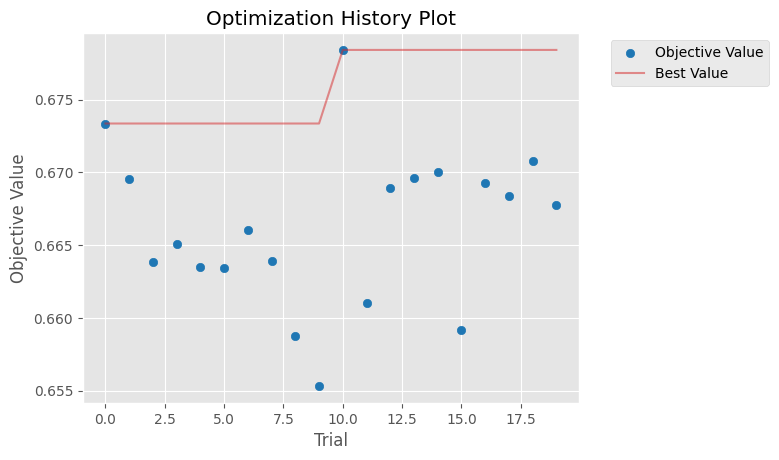

In [16]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_15260\3449611284.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='ngb_learning_rate', ylabel='Objective Value'>,
       <Axes: xlabel='ngb_n_estimators'>], dtype=object)

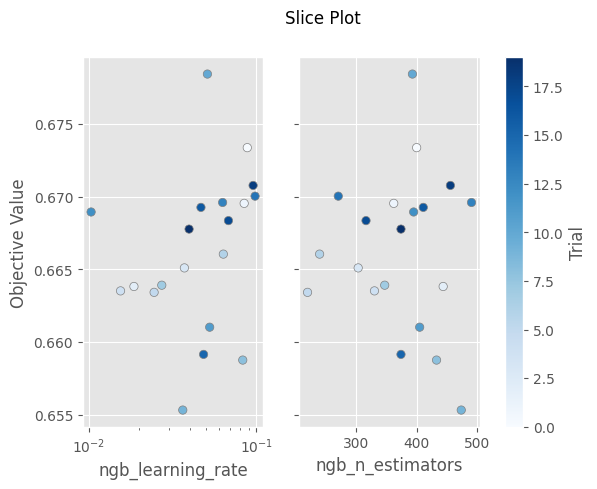

In [17]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["ngb_n_estimators", "ngb_learning_rate"],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_15260\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

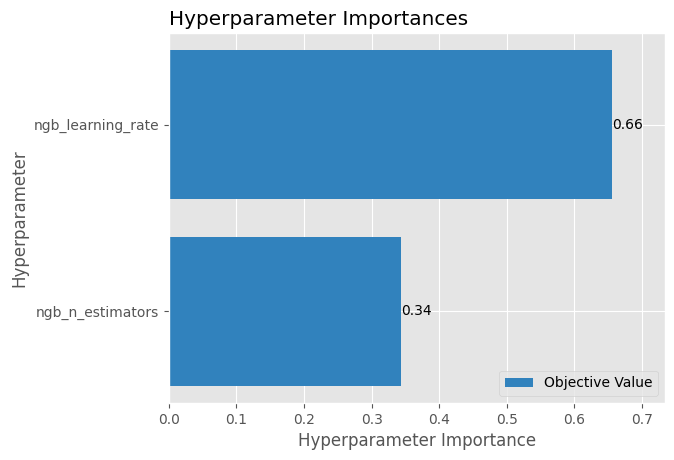

In [18]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_15260\1937692550.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

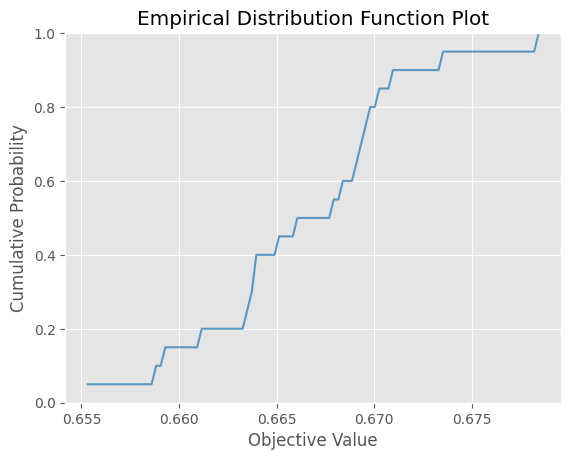

In [19]:
optuna.visualization.matplotlib.plot_edf([study])


### Classification

In [20]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                        n_estimators=study.best_params['ngb_n_estimators'],
                        learning_rate=study.best_params['ngb_learning_rate'], 
                        random_state=42
        )

        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [21]:
trained_ngb_n, metrics_ngb_n = run_model("NGBoost", "Complete", X_train_knn_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", "Boruta", X_train_t, y_train)

[iter 0] loss=0.9909 val_loss=0.0000 scale=2.0000 norm=6.8284
[iter 100] loss=0.3509 val_loss=0.0000 scale=0.5000 norm=1.0066
[iter 200] loss=0.3430 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 300] loss=0.3430 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.9909 val_loss=0.0000 scale=2.0000 norm=6.8284
[iter 100] loss=0.3471 val_loss=0.0000 scale=0.5000 norm=0.9921
[iter 200] loss=0.3349 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 300] loss=0.3349 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.9909 val_loss=0.0000 scale=2.0000 norm=6.8284
[iter 100] loss=0.3325 val_loss=0.0000 scale=0.2500 norm=0.4878
[iter 200] loss=0.3144 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 300] loss=0.3144 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.9909 val_loss=0.0000 scale=2.0000 norm=6.8284
[iter 100] loss=0.3600 val_loss=0.0000 scale=0.0156 norm=0.0322
[iter 200] loss=0.3545 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 300] loss=0.3545 val_loss=0.0000 scale=0.0

In [22]:
validation_df = pd.concat([metrics_ngb_n, metrics_ngb_t])
validation_df_report = validation_df.set_index(["Classifier", "Metric", "Feature Selection", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Classifier Metric            Feature Selection Fit Time Total Features               
NGBoost    balanced_accuracy Complete          8.523    22                   0.766   
                             Boruta            6.206    13                   0.758   

                                                                        Std Train  \
Classifier Metric            Feature Selection Fit Time Total Features              
NGBoost    balanced_accuracy Complete          8.523    22                  0.010   
                             Boruta            6.206    13                  0.008   

                                                                        Mean Test  \
Classifier Metric            Feature Selection Fit Time Total Features              
NGBoost    balanced_accuracy Complete          8.523    22                  0.656   
                             Boruta            6.206    13                  0.678   

                                                                        Std Test  
Classifier Metric            Feature Selection Fit Time Total Features            
NGBoost    balanced_accuracy Complete          8.523    22                 0.030  
                             Boruta            6.206    13                 0.038

In [23]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [24]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [25]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)        
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=1000,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [26]:
results = "all"
prediction_df_report = None

if results == "all":

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_n, pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":

    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier Classification Time Total Features Metric                          
Boruta            NGBoost    1.101               22             accuracy                0.839   
                                                                balanced_accuracy       0.780   
                                                                precision_macro         0.826   
                                                                recall_macro            0.780   
                                                                f1_macro                0.797   
                                                                roc_auc_macro           0.963   
                                                                specificity_macro       0.901   
                             5.373               13             accuracy                0.822   
                                                                balanced_accuracy       0.755   
                                                                precision_macro         0.807   
                                                                recall_macro            0.755   
                                                                f1_macro                0.773   
                                                                roc_auc_macro           0.950   
                                                                specificity_macro       0.890   

                                                                                   Test data  \
Feature Selection Classifier Classification Time Total Features Metric                         
Boruta            NGBoost    1.101               22             accuracy               0.816   
                                                                balanced_accuracy      0.733   
                                                                precision_macro        0.796   
                                                                recall_macro           0.733   
                                                                f1_macro               0.757   
                                                                roc_auc_macro          0.898   
                                                                specificity_macro      0.878   
                             5.373               13             accuracy               0.811   
                                                                balanced_accuracy      0.718   
                                                                precision_macro        0.785   
                                                                recall_macro           0.718   
                                                                f1_macro               0.744   
                                                                roc_auc_macro          0.890   
                                                                specificity_macro      0.875   

                                                                                           95% CI  \
Feature Selection Classifier Classification Time Total Features Metric                              
Boruta            NGBoost    1.101               22             accuracy            [0.78, 0.853]   
                                                                balanced_accuracy  [0.678, 0.782]   
                                                                precision_macro    [0.744, 0.849]   
                                                                recall_macro       [0.679, 0.782]   
                                                                f1_macro           [0.703, 0.805]   
                                                                roc_auc_macro      [0.869, 0.923]   
                                                                specificity_macro  [0.855, 0.902]   
                             5.373               13             accuracy           [

### Export model

In [27]:
trained_ngb_t

NGBClassifier(learning_rate=0.05101318989222467, n_estimators=393,
              random_state=RandomState(MT19937) at 0x251019C3A40)

In [28]:
import pickle

# Save the trained model using pickle
with open("ngboost_model.pkl", "wb") as file:
    pickle.dump(trained_ngb_t, file)

print("NGBoost model saved successfully!")

NGBoost model saved successfully!


In [29]:
# Load the saved model using pickle
with open("ngboost_model.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)